<a href="https://colab.research.google.com/github/mixa15341/Deep_Learning/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%966/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%966_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D1%80%D0%B8%D0%BA%D0%BB%D0%B0%D0%B4%D0%BD%D1%8B%D1%85_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

### - **N.B.: Во всех заданиях, графический интерфейс для взаимодействия с обученной моделью, реализуется с помощью Gradio!**

### - **Для каждого задания в графическом интерфейсе должно быть встроено минимум 3 примера (sample)**

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета.

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [3]:
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, Dense, Input, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import cifar100
(x_train, _), (x_test, _) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Преобразование изображений в черно-белые
x_train_gray = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])
x_test_gray = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140])
x_train_gray = np.expand_dims(x_train_gray, axis=-1)
x_test_gray = np.expand_dims(x_test_gray, axis=-1)
from keras import layers
input = layers.Input(shape=(32, 32, 1))

In [2]:
# Encoder
from keras.layers import BatchNormalization
from keras.optimizers import Adam
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512   

In [3]:
autoencoder.fit(x_train_gray, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_gray, x_test))

Epoch 1/10
391/391 [==============================] - 22s 34ms/step - loss: 0.0131 - val_loss: 0.0406
Epoch 2/10
391/391 [==============================] - 12s 30ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 3/10
391/391 [==============================] - 13s 32ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 4/10
391/391 [==============================] - 11s 29ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 5/10
391/391 [==============================] - 12s 30ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 6/10
391/391 [==============================] - 12s 31ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 7/10
391/391 [==============================] - 11s 28ms/step - loss: 0.0094 - val_loss: 0.0122
Epoch 8/10
391/391 [==============================] - 12s 31ms/step - loss: 0.0093 - val_loss: 0.0107
Epoch 9/10
391/391 [==============================] - 10s 26ms/step - loss: 0.0092 - val_loss: 0.0123
Epoch 10/10
391/391 [==============================] - 11s 27ms/step - loss: 0.009

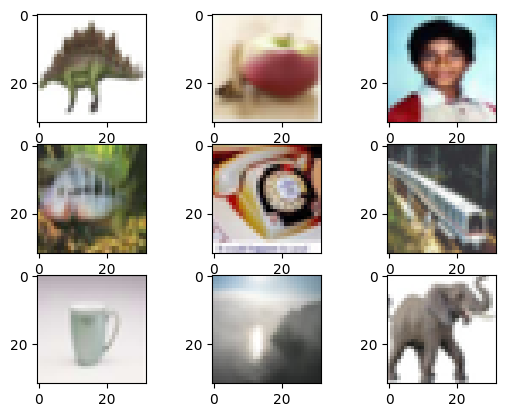

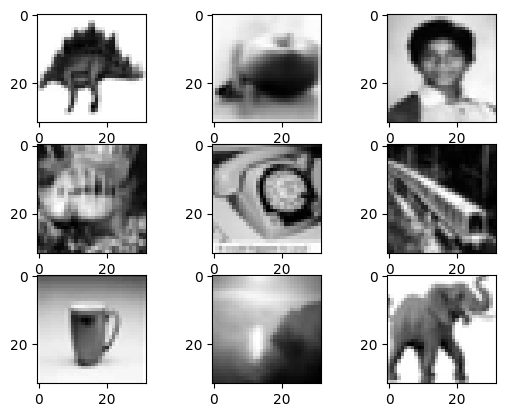

NameError: name 'autoencoder' is not defined

In [6]:
import matplotlib.pyplot as plt
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.show()
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train_gray[i], cmap=plt.get_cmap('gray'))

plt.show()

predictions = autoencoder.predict(x_train_gray)

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(predictions[i], cmap=plt.get_cmap('gray'))

plt.show()

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [4]:
# def noise(image, noise_level=20):
#     noisy_image = image + noise_level * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
#     noisy_image = np.clip(noisy_image, 0, 255)  # Ограничиваем значения пикселей от 0 до 255
#     return noisy_image.astype(np.uint8)

#presprocess the images for grey and color types
def preprocess(array1, array2, channel):
    """
    Normalizes/scales [0,1], divinding by the supplied array and reshapes
    it into the appropriate format.
    """


    if channel==1:
        #here -1 refers to the number of rows(n), n*784
        #on this array
        ar1 = array1.astype('float32').reshape([-1,28,28,1]) / 255.
        ar2 = array2.astype('float32').reshape([-1,28,28,1]) / 255.
    else:
        ar1 = array1.astype('float32').reshape([-1,32,32,3]) / 255
        ar2 = array2.astype('float32').reshape([-1,32,32,3]) / 255
    return ar1, ar2
def noise(a1,a2, channel):
    """
    Adds random noise to each image in the supplied array.
    """
    if channel==1:
        # Adding noise by multiplication of noise factor and
        #gaussian distribution
        noise_factor = 0.2
        noisy_arr1 = a1 + noise_factor * np.random.normal(
        0.0, 1.0, size=a1.shape)
        noisy_arr2 = a2 + noise_factor * np.random.normal(
        0.0, 1.0, size=a2.shape)
    else:

        noi = 0.1
        noisy_arr1 = a1 + noi * np.random.normal(
        0.0, 1.0, size=a1.shape)
        noisy_arr2 = a2 + noi * np.random.normal(
        0.0, 1.0, size=a2.shape)

    #pixel value not in ranged [0,1] cliped
    ab1 = np.clip(noisy_arr1, 0, 1)
    ab2 = np.clip(noisy_arr2, 0, 1)
    return ab1, ab2

# Visualization for mnist, cifar10, noisy, denoised/predictions data
def display(rows, cols, a, b, check=False ):
    '''rows: defining no. of rows in figure
      cols: defining no. of colums in figure
      a: train images without noise or noisy_image while test
      prediction
      b: train images with noise or denoised_image based while test
      prediction
      check: default False for 32*32 cifar10, true for 28*28
      mnist dataset and any predictions
    '''
    # defining a figure
    f = plt.figure(figsize=(2*cols,2*rows*2))
    for i in range(rows):
        for j in range(cols):
            # adding subplot to figure on each iteration
            f.add_subplot(rows*2,cols, (2*i*cols)+(j+1))
            if check:
                plt.imshow(a[i*cols + j].reshape([28,28]),cmap="Blues")
            else:
                plt.imshow(a[i*cols + j])
            plt.axis("off")
        for j in range(cols):
            # adding subplot to figure on each iteration
            f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1))
            if check:
                plt.imshow(b[i*cols + j].reshape([28,28]),cmap="Blues")
            else:
                plt.imshow(b[i*cols + j])
            plt.axis("off")
            plt.axis("off")

    #f.suptitle("Sample Training Data",fontsize=18)
    plt.savefig("ss.png")
    plt.show()

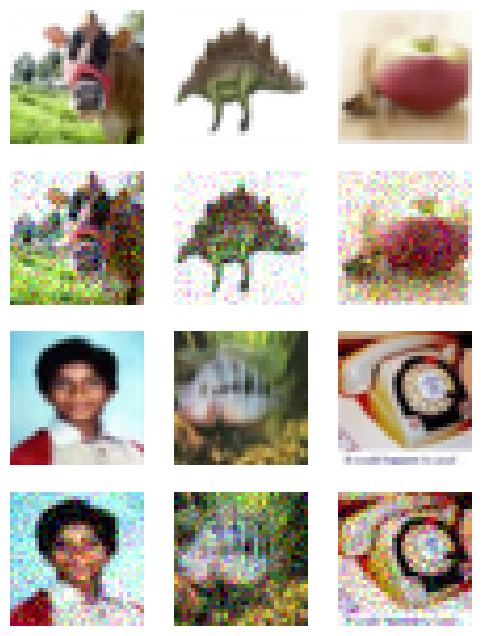

In [7]:
#same as befor 50k for train and 10k test
(cifar_train, _), (cifar_test, _) = cifar100.load_data()
rows=2
cols=3
channel = 3

# Normalize and reshape the data
cifar_train, cifar_test = preprocess(cifar_train,cifar_test, channel)

# Create a copy of the data with added noise
cifar_train_noise, cifar_test_noise = noise(cifar_train,cifar_test, channel)

#display train image with and without noise
display(rows, cols, cifar_train,cifar_train_noise )

In [10]:
input_img = Input(shape=(32, 32, 3))
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, add, LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import Adam
# Encoder

inputs = Input(shape=(32, 32, 3))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x) #standarized the inputs
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
# skip connection for decoder
#convey info, mitigate exploding and and vanishing
#gradient problem
# make activations/output of units/layer not equal 0
skip = Conv2D(32, 3, padding='same')(x)
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
#Conv2DTranspose, the layer will be initialized with
#random weights that will learn
#how to effectively upsample with detail during training.
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x) #normalize x into 0 to 1
x = Dropout(0.5)(x)
#Upsampling and Convolution in one layer
#a crude understanding
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder2 = Model(inputs, decoded)
autoencoder2.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
autoencoder2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 32)           896       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 32, 32, 32)           128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)           0         ['batch_normalization_6[

In [11]:
# Training
epochs = 25
batch_size = 256

history2 = autoencoder2.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test))

Epoch 1/25
196/196 [==============================] - 17s 36ms/step - loss: 0.5602 - val_loss: 0.6018
Epoch 2/25
196/196 [==============================] - 5s 27ms/step - loss: 0.5417 - val_loss: 0.5565
Epoch 3/25
196/196 [==============================] - 5s 26ms/step - loss: 0.5395 - val_loss: 0.5393
Epoch 4/25
196/196 [==============================] - 5s 27ms/step - loss: 0.5383 - val_loss: 0.5371
Epoch 5/25
196/196 [==============================] - 5s 26ms/step - loss: 0.5377 - val_loss: 0.5355
Epoch 6/25
196/196 [==============================] - 5s 28ms/step - loss: 0.5374 - val_loss: 0.5345
Epoch 7/25
196/196 [==============================] - 5s 27ms/step - loss: 0.5371 - val_loss: 0.5345
Epoch 8/25
196/196 [==============================] - 6s 29ms/step - loss: 0.5368 - val_loss: 0.5341
Epoch 9/25
196/196 [==============================] - 5s 27ms/step - loss: 0.5367 - val_loss: 0.5329
Epoch 10/25
196/196 [==============================] - 6s 31ms/step - loss: 0.5364 - val_l

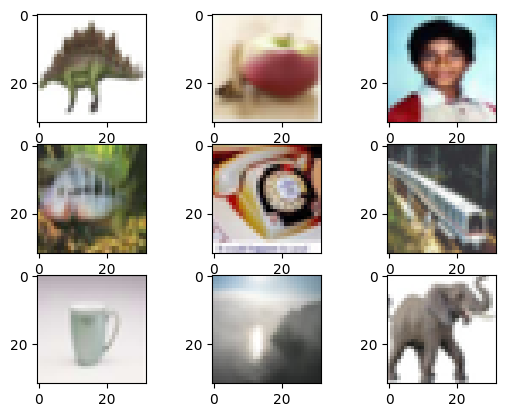

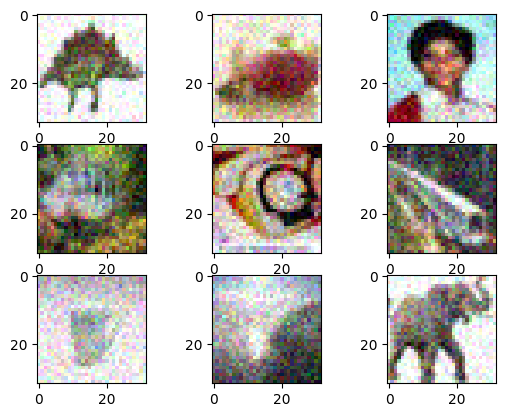

1563/1563 [==============================] - 6s 3ms/step


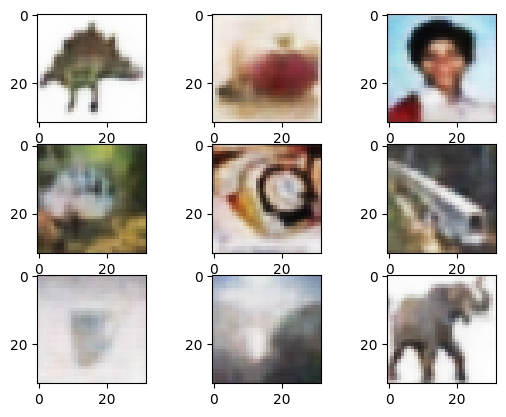

In [13]:
import matplotlib.pyplot as plt
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.show()
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(cifar_train_noise[i], cmap=plt.get_cmap('gray'))

plt.show()

predictions = autoencoder2.predict(cifar_train_noise)

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(predictions[i], cmap=plt.get_cmap('gray'))

plt.show()

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку.

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
(x_train, _), (x_test, _) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [15]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D

# Предварительная обработка данных
# Загрузите данные с изображениями большего разрешения и масштабируйте их до (256, 256, 3)
# Создайте обучающую и тестовую выборки

# Создание модели автоэнкодера для увеличения разрешения изображений
input_img = Input(shape=(256, 256, 3))

# Кодировщик
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Увеличение разрешения (апскейлинг)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение модели
history = autoencoder.fit(x_train, epochs=10, batch_size=16, validation_data=(x_test))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()